<a href="https://colab.research.google.com/github/kegong20242024/ML-Therapy-Prediction/blob/main/Convoloo_12_Encap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files
# uploaded = files.upload()from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/studiendaten_f__r_similarity_analyse_neu.xlsx', engine='openpyxl')

Mounted at /content/drive


In [2]:
!pip install lazypredict
!pip install scikit-multilearn
!pip install xgboost

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from sklearn.metrics import accuracy_score, hamming_loss, make_scorer

from itertools import combinations
from collections import Counter
import io
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.2 MB/s eta 0:00:00


In [3]:
# df = pd.read_excel('studiendaten_f__r_similarity_analyse_neu.xlsx', engine='openpyxl')

Data Preprocessing:
- Invalid Char to NaN
- Values & Column formalization
- Remove non-related columns
  - Eingangsbuvhnumer: serial number
  - Progress: info duplicate
  - Anzahl Metastasen extrahepatisch: all NaN values

In [4]:
#


col1 = 'Wirkstoffschema neoadjuvante Therapie'
col2 = 'Wirkstoffschema adjuvante Therapie'
lower = [s.strip().lower() for s in [
    'entfällt', 'fehlt', 'entfällt/fehlt', 'n.r.', 'enfällt', 'k.a.', 'k.a', 'keine angabe'
]]
unwanted = ['fehlt']


def clean_except(df, lower, unwanted, col1, col2):
    def clean_cell_general(x):

        if isinstance(x, str):
            return x.strip().lower()
        return x

    def clean_cell_with_nulling(x):

        if isinstance(x, str):
            x_cleaned = x.strip().lower()
            return None if x_cleaned in lower or x_cleaned in unwanted else x_cleaned
        return x

    for col in df.columns:
        if col in [col1, col2]:
            df[col] = df[col].apply(clean_cell_general)
        else:
            df[col] = df[col].apply(clean_cell_with_nulling)
    return df


df = clean_except(df, lower, unwanted, col1, col2)


columns_to_drop = ['Eingangsbuchnummer', 'Progress', 'Anzahl Metastasen extrahepatisch']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


df.columns = df.columns.str.strip()

In [5]:
df.head()

,Zugehörigkeit zu Studie,Geschlecht,Alter des Patienten bei Diagnose,Geburtsdatum,OP Datum,Progress Datum,Nachsorge Datum,PFS,early Progress 1=nein; 2= ja,Vitalstatus,...,Tumormarker 1,Tumormarker 2,neoadjuvante Chemotherapie,Wirkstoffschema neoadjuvante Therapie,Therapieerfolg neoadjuvante Therapie,adjuvante Chemotherapie,Wirkstoffschema adjuvante Therapie,Vorerkrankungen,Adjuvante Therapie des Primärtumors oder vorhergeganener Metastase,Wirkstoffschema der Adjuvanten Therapie des Primärtumors oder vorhergegangener Metastase
0,spheropct,weiblich,65.0,1940-07-28 00:00:00,2006-01-25 00:00:00,kein progress,2016-08-25 00:00:00,127.0,kein progress,lebt noch,...,cea im normbereich,ca19-9 im normbereich,None,entfällt,None,keine,keine,ja,None,None
1,spheropct,männlich,71.0,1934-08-05 00:00:00,2006-04-28 00:00:00,kein progress,2015-11-28 00:00:00,115.0,kein progress,lebt noch,...,cea im normbereich,ca19-9 pathologisch,None,entfällt,None,keine,keine,ja,None,None
2,spheropct,männlich,70.0,1935-05-05 00:00:00,2006-05-22 00:00:00,kein progress,2013-01-22 00:00:00,80.0,kein progress,lebt noch,...,cea im normbereich,ca19-9 im normbereich,None,entfällt,None,keine,keine,ja,None,None
3,spheropct,männlich,64.0,1942-04-11 00:00:00,2006-05-08 00:00:00,kein progress,2016-06-08 00:00:00,121.0,kein progress,lebt noch,...,cea im normbereich,ca19-9 im normbereich,None,entfällt,None,keine,keine,nein,None,None
4,spheropct,männlich,62.0,1944-07-13 00:00:00,2006-09-19 00:00:00,kein progress,19-oct-2008,25.0,kein progress,lebt noch,...,cea im normbereich,ca19-9 im normbereich,None,entfällt,None,keine,keine,ja,None,None


NaN value visualization Bar Chart

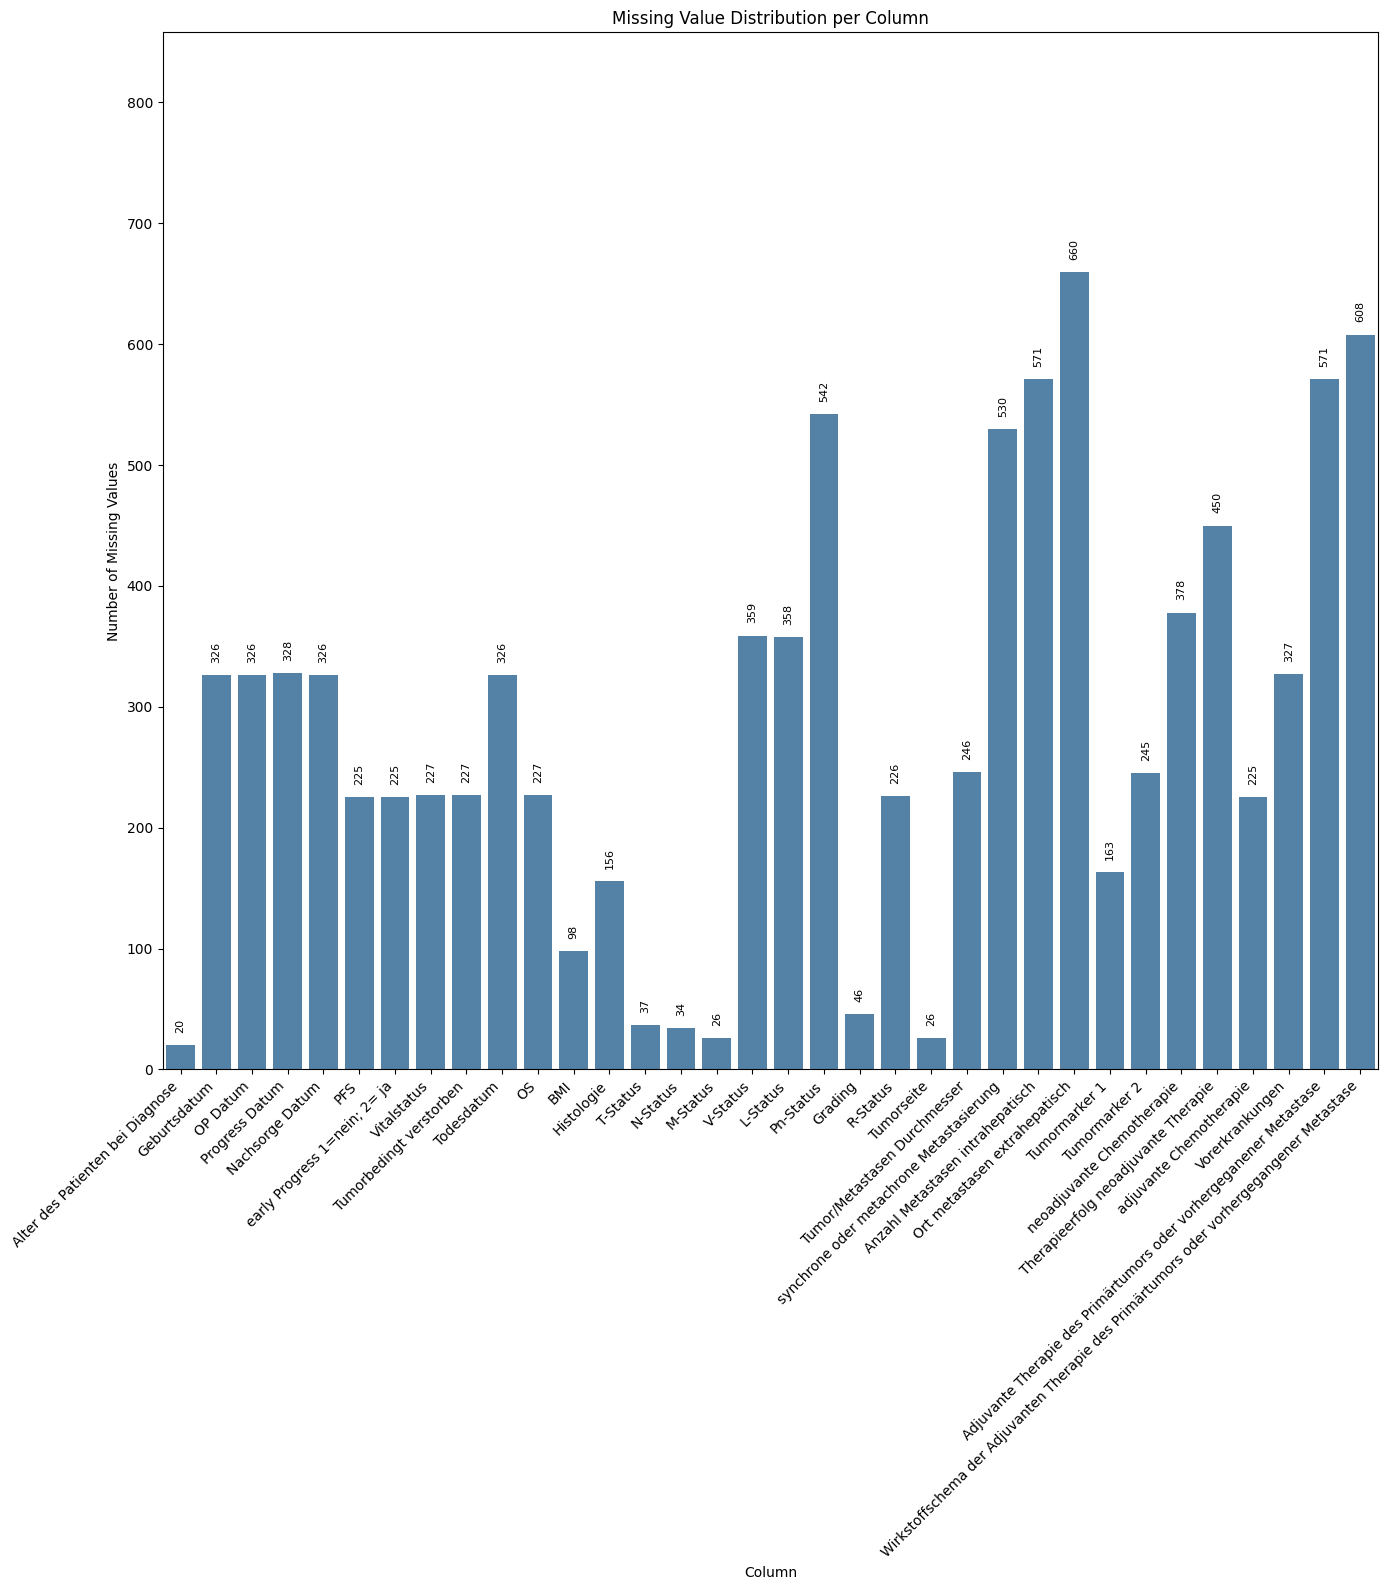

In [6]:
# missing val visualization
nan_counts = df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]

plt.figure(figsize=(14, 16))
sns.barplot(x=nan_counts.index, y=nan_counts.values, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.title('Missing Value Distribution per Column')
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.ylim(0, nan_counts.max() * 1.3)
for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 10, str(val), ha='center', va='bottom', fontsize=8, rotation=90)
plt.tight_layout()
plt.show()


Dealing NaN value: cleaning Class

In [7]:

df_filled = df.copy()

# Delete the rows where both are empty (including 'nein', 'keine')
col1 = 'Wirkstoffschema neoadjuvante Therapie'
col2 = 'Wirkstoffschema adjuvante Therapie'



Dealing NAN values: Median & Mode

In [8]:
# Median
numerical_median_fill = [
    'Alter des Patienten bei Diagnose', 'BMI', 'PFS', 'OS',
    'Tumor/Metastasen Durchmesser', 'Anzahl Metastasen intrahepatisch',
    'Anzahl Metastasen extrahepatisch'
]

for col in numerical_median_fill:
    if col in df_filled.columns:
        df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')
        median_val = df_filled[col].median()
        df_filled[col] = df_filled[col].fillna(median_val)

# Mode
categorical_mode_fill = [
    'T-Status', 'N-Status', 'M-Status',
    'V-Status', 'L-Status', 'Pn-Status','Grading', 'R-Status',
    'Tumorseite', 'Histologie'
    , 'Vitalstatus','Tumorbedingt verstorben', 'synchrone oder metachrone Metastasierung',
    'Tumormarker 1', 'Tumormarker 2','Therapieerfolg neoadjuvante Therapie', 'adjuvante Chemotherapie',
    'Vorerkrankungen','early Progress 1=nein; 2= ja', 'neoadjuvante Chemotherapie'
]

for col in categorical_mode_fill:
    if col in df_filled.columns:
        mode_val = df_filled[col].mode()[0]
        df_filled[col] = df_filled[col].fillna(mode_val)

#Drop Colume(since cannot estimate date & missing > 250)
drop_col = ['Geburtsdatum', 'Progress Datum','OP Datum', 'Nachsorge Datum', 'Todesdatum', 'Ort metastasen extrahepatisch',
            'Adjuvante Therapie des Primärtumors oder vorhergeganener Metastase','Wirkstoffschema der Adjuvanten Therapie des Primärtumors oder vorhergegangener Metastase', 'Pn-Status']
df_filled = df_filled.drop(columns=[col for col in drop_col if col in df.columns])

Check Any NAN

In [9]:
total_missing = df_filled.isna().sum().sum()
if total_missing == 0:
    print("no NAN")
else:
    print(f"{total_missing} NAN")
# missing val visualization
# total_missing = df_filled.isna().sum().sum()
# if total_missing == 0:
#     print("no NAN")
# else:
#     print(f"{total_missing} NAN")

nan_counts = df_filled.isna().sum()
nan_counts = nan_counts[nan_counts > 0]

# plt.figure(figsize=(14, 16))
# sns.barplot(x=nan_counts.index, y=nan_counts.values, color='salmon')
# plt.xticks(rotation=45, ha='right')
# plt.title('Remaining Missing Value Distribution per Column')
# plt.xlabel('Column')
# plt.ylabel('Number of Missing Values')
# plt.ylim(0, nan_counts.max() * 1.3)
# for i, val in enumerate(nan_counts.values):
#     plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=8, rotation=90)
# plt.tight_layout()
# plt.show()

no NAN


Save to filled_dataset

In [10]:
df_filled.to_excel("filled_dataset.xlsx", index=False)
from google.colab import files
files.download("filled_dataset.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label Encoding

In [11]:
df_encoded = df_filled.copy()

# Determine the categorical variable columns that need to be encoded (excluding non-categorical, excluding time columns, etc.)
exclude_cols = ['Todesdatum', 'Progress Datum', 'Nachsorge Datum', col1, col2]
categorical_columns = [col for col in df_encoded.select_dtypes(include=['object', 'category']).columns if col not in exclude_cols]

# encoding
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].astype(str).str.strip()         # remove space
    df_encoded[col] = df_encoded[col].replace('nan', np.nan)          # transfer to NaN
    df_encoded[col] = df_encoded[col].fillna('Missing')               # replace missing temporaly
    df_encoded[col] = le.fit_transform(df_encoded[col])               # encoding
    label_encoders[col] = le                                          # sace code


df_encoded.to_excel("numerical.xlsx", index=False)
from google.colab import files
files.download("numerical.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlation Matrix Calculation

In [12]:
numeric_df = df_encoded.select_dtypes(include=[np.number])
if 'Wirkstoffschema adjuvante Therapie' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['Wirkstoffschema adjuvante Therapie'])



def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# automatically select all categorical columns (excluding the target column)
target_column = 'Wirkstoffschema neoadjuvante Therapie'

categorical_cols = df_filled.select_dtypes(include=['object', 'category']).columns.tolist()
if target_column in categorical_cols:
    categorical_cols.remove(target_column)

# Construct the Cramér’s V matrix and remove highly correlated columns (while retaining specified columns)
target_cols_to_keep = {'Wirkstoffschema neoadjuvante Therapie', 'Wirkstoffschema adjuvante Therapie'}
threshold = 0.75
to_drop = set()

cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1_iter, col2_iter in combinations(categorical_cols, 2):
    if col1_iter == col2_iter:
        cramer_matrix.loc[col1_iter, col2_iter] = 1.0
        continue

    try:
        confusion_matrix = pd.crosstab(df_filled[col1_iter], df_filled[col2_iter])
        if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
            continue
        chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        denom = min(k - 1, r - 1)
        if denom == 0:
            continue
        v = np.sqrt(phi2 / denom)
        cramer_matrix.loc[col1_iter, col2_iter] = v
        cramer_matrix.loc[col2_iter, col1_iter] = v
        if v > threshold and col2_iter not in target_cols_to_keep:
            to_drop.add(col2_iter)

    except Exception:
        continue

# remove high relevalce columns
categorical_cols = [col for col in categorical_cols if col not in to_drop]
reduced_df = df_encoded.select_dtypes(include=[np.number])
if target_column in reduced_df.columns:
    reduced_df = reduced_df.drop(columns=[target_column])

cramer_matrix = cramer_matrix.astype(float)
print(f"Dropped due to high correlation (>{threshold}): {sorted(to_drop)}")


Dropped due to high correlation (>0.75): ['Hauptdiagnose PT', 'N-Status', 'R-Status', 'Sample site', 'Sample type', 'T-Status', 'Therapieerfolg neoadjuvante Therapie', 'Tumorbedingt verstorben', 'adjuvante Chemotherapie', 'synchrone oder metachrone Metastasierung']


All Correlation Index

In [13]:
cramer_pair_values = []
for col1, col2 in combinations(categorical_cols, 2):
    val = cramer_matrix.loc[col1, col2]
    if pd.notna(val):
        cramer_pair_values.append((col1, col2, float(val)))
        cramer_pair_values.append((col2, col1, float(val)))

cramer_values_df = pd.DataFrame(cramer_pair_values, columns=["Column 1", "Column 2", "Cramér's V"])
cramer_values_df.sort_values(by="Cramér's V", ascending=False, inplace=True)

print("All Cramér's V Correlation Values:")
print(cramer_values_df.to_string(index=False))

All Cramér's V Correlation Values:
                          Column 1                           Column 2  Cramér's V
Wirkstoffschema adjuvante Therapie            Zugehörigkeit zu Studie    0.992955
           Zugehörigkeit zu Studie Wirkstoffschema adjuvante Therapie    0.992955
                        Geschlecht Wirkstoffschema adjuvante Therapie    0.711636
Wirkstoffschema adjuvante Therapie                         Geschlecht    0.711636
           Zugehörigkeit zu Studie                        Vitalstatus    0.707242
                       Vitalstatus            Zugehörigkeit zu Studie    0.707242
      early Progress 1=nein; 2= ja Wirkstoffschema adjuvante Therapie    0.676361
Wirkstoffschema adjuvante Therapie       early Progress 1=nein; 2= ja    0.676361
                        Geschlecht            Zugehörigkeit zu Studie    0.675478
           Zugehörigkeit zu Studie                         Geschlecht    0.675478
                        Histologie         neoadjuvante Chemoth

Heat Graph

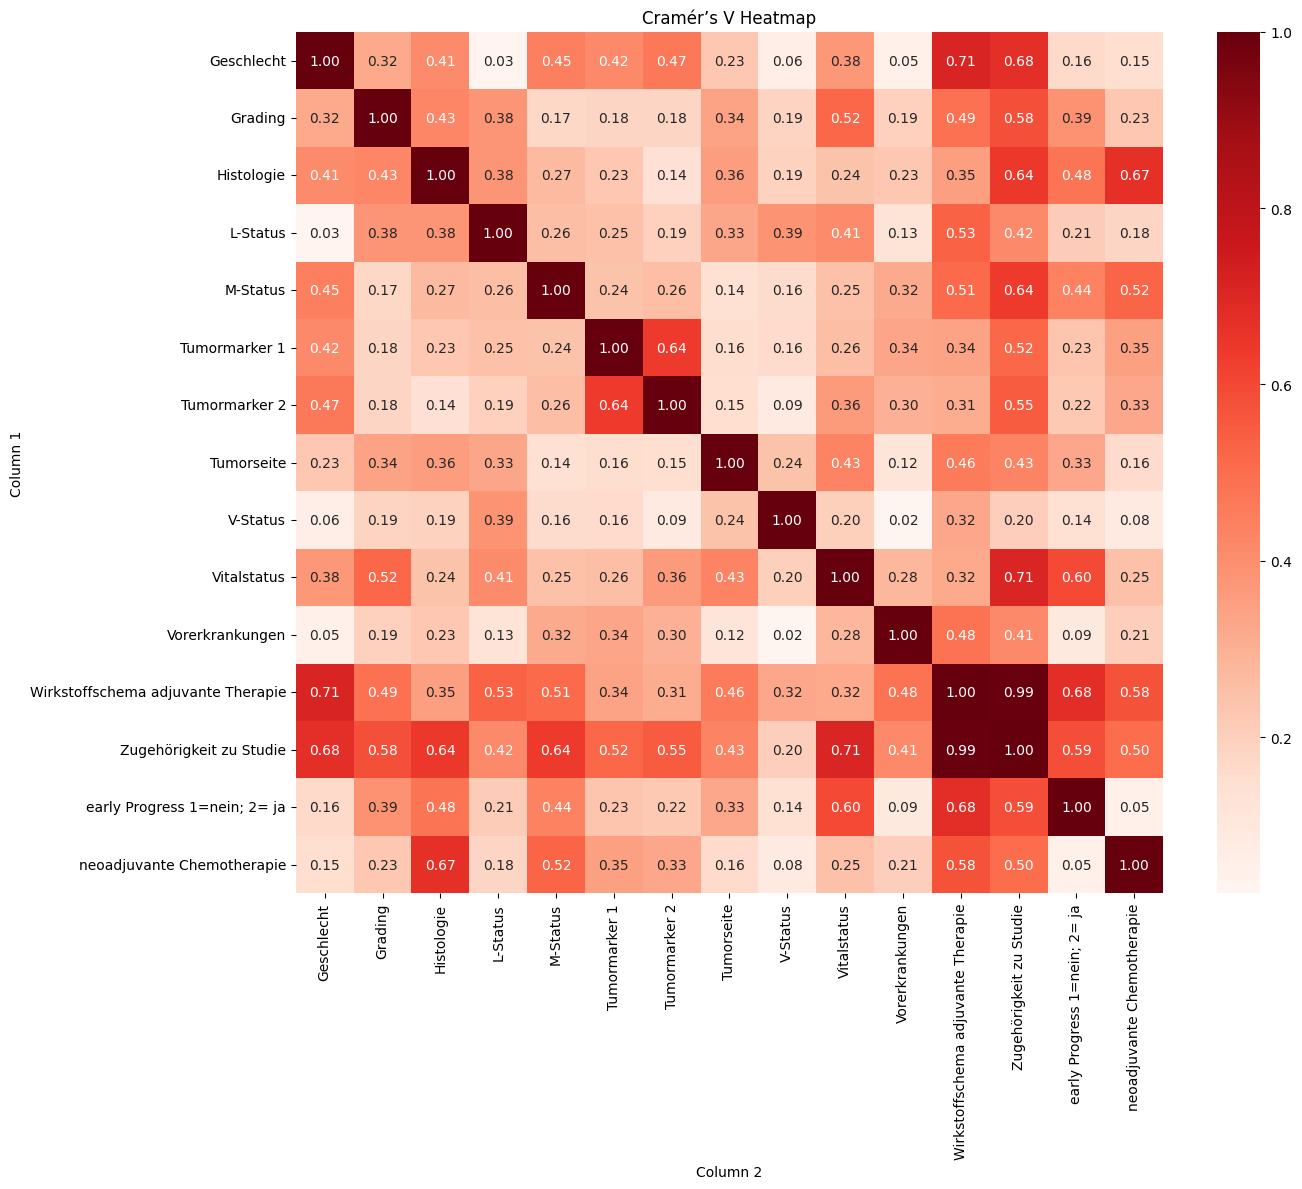

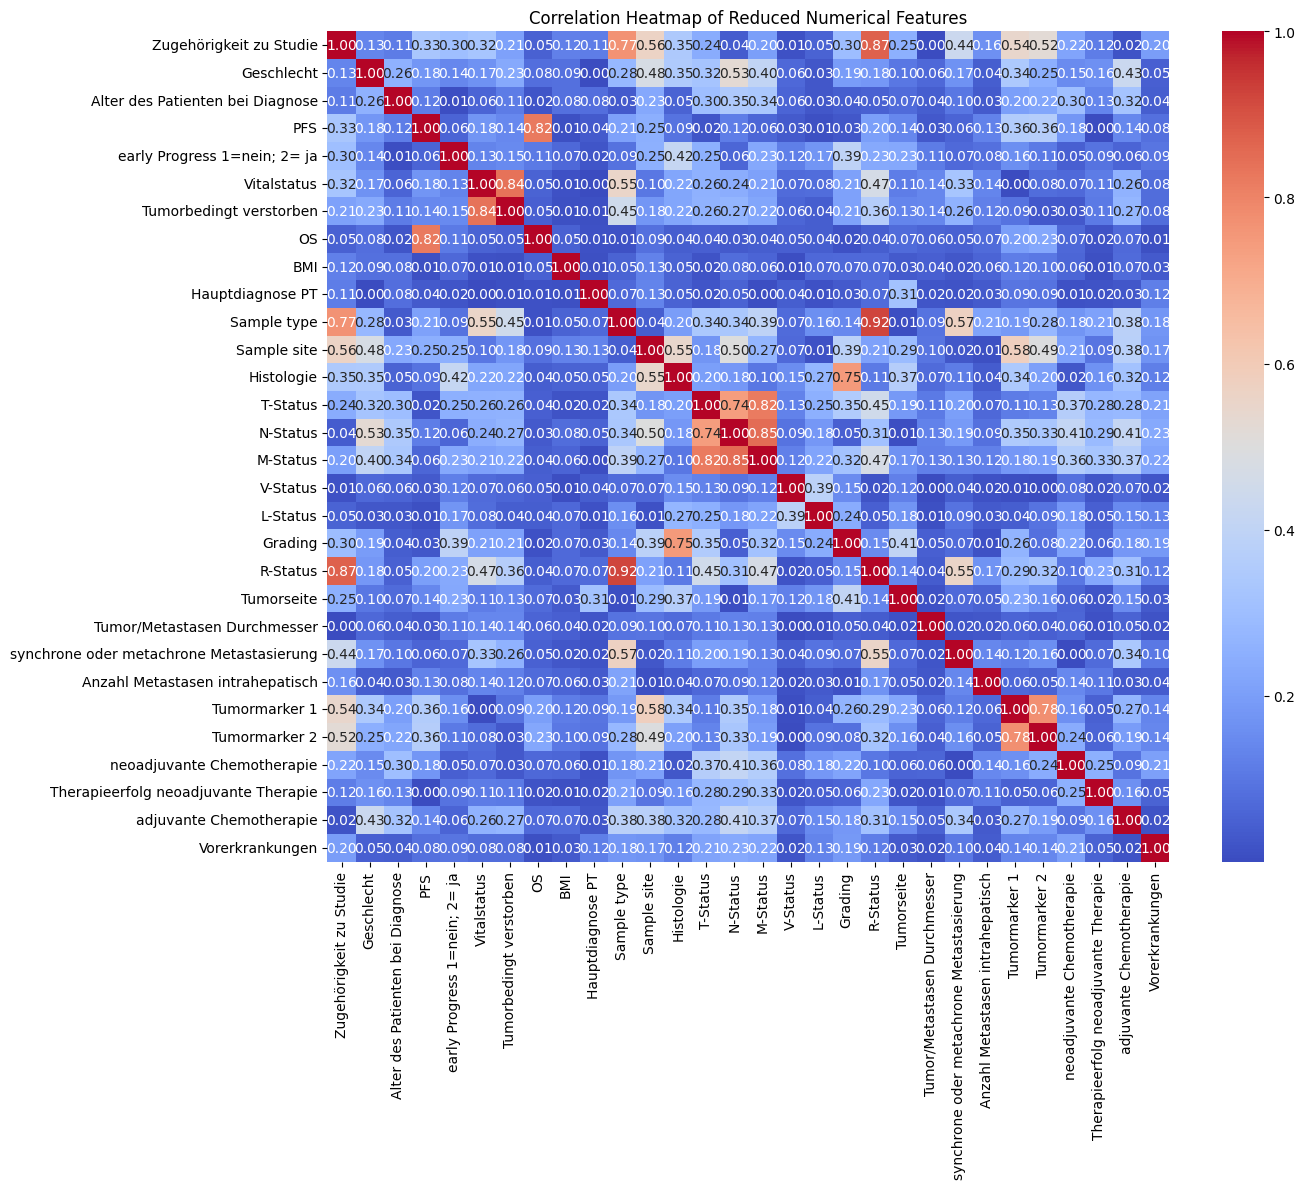

In [14]:

# HEat Graph
pivot_matrix = cramer_values_df.pivot(index='Column 1', columns='Column 2', values="Cramér's V")

for col1, col2, val in cramer_pair_values:
    pivot_matrix.loc[col2, col1] = val
for col in pivot_matrix.columns:
    pivot_matrix.loc[col, col] = 1.0

pivot_matrix = pivot_matrix.astype(float)

plt.figure(figsize=(14, 12))
sns.heatmap(pivot_matrix, annot=True, cmap="Reds", fmt=".2f")
plt.title("Cramér’s V Heatmap")
plt.tight_layout()
plt.show()

# # remove high relevalce columns

categorical_cols = [col for col in categorical_cols if col not in to_drop]

reduced_df = df_encoded.select_dtypes(include=[np.number])
if target_column in reduced_df.columns:
    reduced_df = reduced_df.drop(columns=[target_column])


corr_matrix = reduced_df.corr(method='pearson').abs()


plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Reduced Numerical Features")
plt.tight_layout()
plt.show()


Lazy Predict

In [15]:
# !pip install lazypredict
col1 = 'Wirkstoffschema neoadjuvante Therapie'
col2 = 'Wirkstoffschema adjuvante Therapie'
target_column = col2
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X = df_encoded[reduced_df.columns]
y = df_encoded[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)



  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 29
[LightGBM] [Info] Start training from score -5.998937
[LightGBM] [Info] Start training from score -5.998937
[LightGBM] [Info] Start training from score -5.305789
[LightGBM] [Info] Start training from score -3.919495
[LightGBM] [Info] Start training from score -5.998937
[LightGBM] [Info] Start training from score -5.998937
[LightGBM] [Info] Start training from score -5.998937
[LightGBM] [Info] Start training from score -4.207177
[LightGBM] [Info] Start training from score -2.666732
[LightGBM] [Info] Start training from score -2.415418
[LightGBM] [Info] Start training from score -1.036092
[LightGBM] [Info] Start training from score -5.998937
[L

In [16]:
print(X_train.shape)

(403, 30)


classification

In [17]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.preprocessing import StandardScaler, LabelEncoder

Random Forest train and evaluate

In [18]:
#

def encode_target(df_encoded, target_column):
    y = df_encoded[target_column]
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

def prepare_features(df_encoded, reduced_df, target_column=None):
    X = df_encoded[reduced_df.columns]
    if target_column and target_column in X.columns:
        X = X.drop(columns=[target_column])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns)

def split_data(X, y, test_size=0.4, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_model(X_train, y_train, model_type='rf', random_state=42):
    if model_type == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    elif model_type == 'bagging':
        model = BaggingClassifier(n_estimators=100, random_state=random_state)
    else:
        raise ValueError("model_type must be either 'rf' or 'bagging'")
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return y_pred, acc

def plot_feature_importance(model, feature_names, top_n=5, title_prefix=""):
    if not hasattr(model, "feature_importances_"):
        print(f"{title_prefix}: Feature importance not available.")
        return pd.DataFrame()
    importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n), palette='Reds_r')
    plt.title(f"{title_prefix} Top {top_n} Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

    return importance_df

def export_results(importance_df, y_test, y_pred, label_encoder, target_column, model_tag=""):
    tag = f"{target_column.replace(' ', '_')}_{model_tag}"
    feature_file = f"features_{tag}.xlsx"
    prediction_file = f"actual_vs_predicted_{tag}.xlsx"

    if not importance_df.empty:
        importance_df.to_excel(feature_file, index=False)
        files.download(feature_file)

    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    comparison_df = pd.DataFrame({
        'Actual Therapy': y_test_decoded,
        'Predicted Therapy': y_pred_decoded
    })
    print(f"\n>>> {model_tag.upper()} Prediction Sample:")
    print(comparison_df.head(10))
    comparison_df.to_excel(prediction_file, index=False)
    files.download(prediction_file)

    return feature_file, prediction_file, comparison_df

def run_pipeline(df_filled, df_encoded, reduced_df, target_column, model_type='rf', test_size=0.4, top_n_features=5):
    """
    Run classification for a single target_column using either Random Forest or Bagging.
    """
    print(f"\n=== Running {model_type.upper()} classification for: {target_column} ===")
    y_encoded, label_encoder = encode_target(df_encoded, target_column)
    y = pd.Series(y_encoded).reset_index(drop=True)
    X = prepare_features(df_encoded, reduced_df, target_column).reset_index(drop=True)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)
    model = train_model(X_train, y_train, model_type=model_type)
    y_pred, acc = evaluate_model(model, X_test, y_test)
    print(f"{model_type.upper()} Accuracy: {acc:.4f}")
    importance_df = plot_feature_importance(model, X.columns, top_n=top_n_features, title_prefix=model_type.upper())
    feature_file, prediction_file, comparison_df = export_results(
        importance_df, y_test, y_pred, label_encoder, target_column, model_tag=model_type
    )

    return {
        "accuracy": acc,
        "feature_file": feature_file,
        "prediction_file": prediction_file,
        "importance_df": importance_df,
        "comparison_df": comparison_df
    }

First Theraphy as target

In [19]:
# print(f"col1 = {col1}")
# col1 = 'Wirkstoffschema neoadjuvante Therapie'
# col2 = 'Wirkstoffschema adjuvante Therapie'
# results = run_pipeline(
#     df_filled=df_filled,
#     df_encoded=df_encoded,
#     reduced_df=reduced_df,
#     target_column=col1,
#     model_type='bagging',
#     test_size=0.2,
#     top_n_features=5
# )
# print(f"col1 = {col1}")




Second theraphy as target

In [20]:

# # # filter out the non-effective second therapy
# # if col2 == 'Wirkstoffschema adjuvante Therapie':
# #     mask = df_filled['Therapieerfolg neoadjuvante Therapie'].astype(str).str.strip().str.lower() != 'nein'
# #     df_filled = df_filled[mask].reset_index(drop=True)
# #     df_encoded = df_encoded[mask].reset_index(drop=True)
# #     print(f"Filtered for col2: {mask.sum()} rows retained (Therapieerfolg neoadjuvante Therapie ！= 'nein')")

# #run
# results = run_pipeline(
#     df_filled=df_filled,
#     df_encoded=df_encoded,
#     reduced_df=reduced_df,
#     target_column= col2,
#     model_type='rf',
#     test_size=0.2,
#     top_n_features=5
# )

Multi-Labeling

In [22]:
col1 = 'Wirkstoffschema neoadjuvante Therapie'
col2 = 'Wirkstoffschema adjuvante Therapie'
multi_target_cols = [col1, col2]

y_raw = df_encoded[multi_target_cols].astype(str)
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(y_raw)

y_df = pd.DataFrame(y, columns=ohe.get_feature_names_out(multi_target_cols))


print(y_df.head(10).to_string(index=False))

X = df_encoded.drop(columns=multi_target_cols)
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

models = {
    "MultiOutput-RF": MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "ClassifierChain-RF": ClassifierChain(RandomForestClassifier(n_estimators=100, random_state=42)),
    # "LabelPowerset-RF": LabelPowerset(RandomForestClassifier(n_estimators=100, random_state=42)),
    "LabelPowerset-RF": LabelPowerset(XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )),
} #try out different algorithms other than RF to compare accuracy

results = []

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if not isinstance(y_pred, np.ndarray):
            y_pred = y_pred.toarray()

        subset_acc = accuracy_score(y_test, y_pred)
        hamming = hamming_loss(y_test, y_pred)

        results.append({
            'Model': name,
            'Subset Accuracy': round(subset_acc, 4),
            'Hamming Loss': round(hamming, 4)
        })
    except Exception as e:
        print(f"Error in {name}: {e}")
        results.append({
            'Model': name,
            'Subset Accuracy': 'Error',
            'Hamming Loss': 'Error'
        })

results_df = pd.DataFrame(results)
print("\n Multi-label Model Comparison:")
print(results_df)




 Wirkstoffschema neoadjuvante Therapie_12x pacl. +h -> 4x ec + h  Wirkstoffschema neoadjuvante Therapie_2x ec  Wirkstoffschema neoadjuvante Therapie_2x ec -> 6x pacl. + carbopl.  Wirkstoffschema neoadjuvante Therapie_3x e -> 3x pacl. +h-> 3x cyclo + h  Wirkstoffschema neoadjuvante Therapie_3x e -> 3x pacl. -> 3x c  Wirkstoffschema neoadjuvante Therapie_3xfec --> 3x doc  Wirkstoffschema neoadjuvante Therapie_4x ec  Wirkstoffschema neoadjuvante Therapie_4x ec + bevaci -> 4x doc + bevaci  Wirkstoffschema neoadjuvante Therapie_4x ec -> 12x pacl.  Wirkstoffschema neoadjuvante Therapie_4x ec -> 12x pacl. + h  Wirkstoffschema neoadjuvante Therapie_4x ec -> 12x pacl. + rad001  Wirkstoffschema neoadjuvante Therapie_4x ec -> 12x pacl. , h  Wirkstoffschema neoadjuvante Therapie_4x ec -> 3x pacl. umstellung -> 9x nab-pacl  Wirkstoffschema neoadjuvante Therapie_4x ec -> 4x carb. + doc  Wirkstoffschema neoadjuvante Therapie_4x ec -> carbopl. + pacl.  Wirkstoffschema neoadjuvante Therapie_4x ec -> d 

Apply LabelPowerset_RF for Significant Features

Top 20 Important Features (from LabelPowerset-RF):
                             Feature  Importance
             adjuvante Chemotherapie        0.10
             Zugehörigkeit zu Studie        0.07
    Alter des Patienten bei Diagnose        0.06
                            N-Status        0.06
          neoadjuvante Chemotherapie        0.06
                                 BMI        0.05
                          Histologie        0.05
                         Sample site        0.05
                            T-Status        0.05
                                 PFS        0.04
                            R-Status        0.04
                             Grading        0.04
        Tumor/Metastasen Durchmesser        0.04
                                  OS        0.04
                            M-Status        0.03
Therapieerfolg neoadjuvante Therapie        0.03
                    Hauptdiagnose PT        0.03
                       Tumormarker 1        0.02
                  

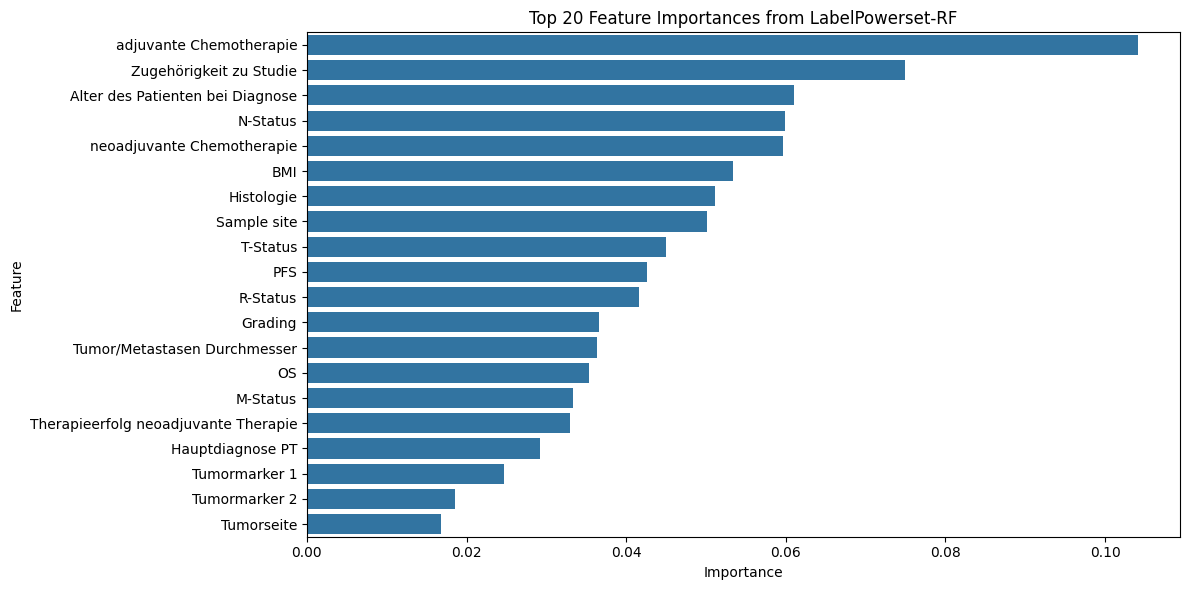

In [24]:


lp_model = LabelPowerset(RandomForestClassifier(n_estimators=100, random_state=42)) # Lable powerset model training
lp_model.fit(X_train, y_train)


lp_importances = lp_model.classifier.feature_importances_ # extract significant features


lp_feature_importance_df = pd.DataFrame({
    'Feature': reduced_df.columns,
    'Importance': lp_importances
}).sort_values(by='Importance', ascending=False)


print("Top 20 Important Features (from LabelPowerset-RF):")
print(lp_feature_importance_df.head(20).to_string(index=False)) #top 20


plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=lp_feature_importance_df.head(20))
plt.title("Top 20 Feature Importances from LabelPowerset-RF")
plt.tight_layout()
plt.show()

optimizing hyperparameters

In [25]:
def multilabel_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

scorer = make_scorer(multilabel_score, greater_is_better=True)

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

lp_model = LabelPowerset(RandomForestClassifier(random_state=42))

grid_search = GridSearchCV(estimator=lp_model,
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=3,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Final Test Subset Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Final Test Hamming Loss:", round(hamming_loss(y_test, y_pred), 4))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None